In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Baselines

## Unprocessed data

### Random predictor

In [4]:
unprocessed_df = pd.read_csv("dlomix/data/prelim_unprocessed_data.csv")

In [5]:
# define minimum and maximum charge state
min_charge_state = 1
max_charge_state = 6

In [6]:
# Generate random charge states for each sequence
random_predictions = np.random.randint(min_charge_state, max_charge_state+1, size=len(unprocessed_df))
unprocessed_df['random_prediction'] = random_predictions
unprocessed_df.head()

,Unnamed: 0,modified_sequence,precursor_charge,precursor_intensity,random_prediction
0,0,LPGSLETYVEQEQGENANDR,2,29525630.0,3
1,1,HGSLQEYLQNDTGSK,2,13188580.0,3
2,2,VEEEEEINSELTAR,2,20663460.0,6
3,3,SELGSFITDYFQNQLLAK,2,22051180.0,3
4,4,ETTGAQVQVAGDLLPNSTER,2,16059520.0,2


In [7]:
# Calculate the accuracy of the random predictor
accuracy = accuracy_score(unprocessed_df['precursor_charge'], unprocessed_df['random_prediction'])

print(f"Accuracy of the random predictor: {accuracy:.2f}")
print(classification_report(unprocessed_df['precursor_charge'], unprocessed_df['random_prediction']))

Accuracy of the random predictor: 0.17


/root/miniforge3/envs/pcp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniforge3/envs/pcp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           1       0.04      0.17      0.07   2396943
           2       0.67      0.17      0.27  37936853
           3       0.25      0.17      0.20  14304050
           4       0.04      0.17      0.06   2186417
           5       0.00      0.17      0.01    174130
           6       0.00      0.17      0.00     13990
           7       0.00      0.00      0.00      1035

    accuracy                           0.17  57013418
   macro avg       0.14      0.14      0.09  57013418
weighted avg       0.51      0.17      0.23  57013418



/root/miniforge3/envs/pcp_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Random predictor with distribution bias

In [8]:
# Calculate the distribution of precursor_charges
charge_distribution = unprocessed_df['precursor_charge'].value_counts(normalize=False)

charge_distribution

precursor_charge
2    37936853
3    14304050
1     2396943
4     2186417
5      174130
6       13990
7        1035
Name: count, dtype: int64

In [11]:
# Use the calculated distribution to randomly assign charge states
charges = charge_distribution.index.to_list()
probabilities = charge_distribution.values

# Generate random charge states for each sequence
random_assigned_charges = np.random.choice(charges, size=len(unprocessed_df), p=probabilities)
unprocessed_df['biased_random_prediction'] = random_assigned_charges
unprocessed_df.head() 

ValueError: probabilities do not sum to 1

In [10]:
# Calculate the accuracy of the random predictor
accuracy = accuracy_score(unprocessed_df['precursor_charge'], unprocessed_df['biased_random_prediction'])

print(f"Accuracy of the random predictor: {accuracy:.2f}")
print(classification_report(unprocessed_df['precursor_charge'], unprocessed_df['biased_random_prediction']))

KeyError: 'biased_random_prediction'

### Mjority Baseline (single charge)

In [18]:
def majority_baseline(df, k=1):
    # Check if the required column exists in the dataframe
    if 'precursor_charge' not in df.columns:
        raise ValueError("The dataframe must contain a 'precursor_charge' column")

    # Count occurrences of each precursor charge
    charge_counts = df['precursor_charge'].value_counts()
    
    # Get the top-k charges
    top_k_charges = charge_counts.nlargest(k).index.tolist()
    
    # For baseline prediction, use the top charge for all data points
    top_charge = top_k_charges[0]
    baseline_predictions = [top_charge] * len(df)
    
    # Evaluate the baseline using the actual charges
    actual_charges = df['precursor_charge'].tolist()
    
    # Generate evaluation metrics
    accuracy = accuracy_score(actual_charges, baseline_predictions)
    report = classification_report(actual_charges, baseline_predictions, labels=[top_charge], zero_division=0)

    print(f"top_k_charges: {top_k_charges}")
    print(f"Accuracy of the majority baseline: {accuracy:.2f}")
    print(report)
    return{
        "accuracy": accuracy,
        "report": report,
        "top_k_charges": top_k_charges
    }

In [19]:
baseline_metrics = majority_baseline(unprocessed_df, k=2)

top_k_charges: [2, 3]
Accuracy of the majority baseline: 0.67
              precision    recall  f1-score   support

           2       0.67      1.00      0.80  37936853

   micro avg       0.67      1.00      0.80  37936853
   macro avg       0.67      1.00      0.80  37936853
weighted avg       0.67      1.00      0.80  37936853



### Majority Baseline (top-k charges)

## Preprocessed data

In [35]:
# Load the dataset
df = pd.read_csv("dlomix/data/prelim_preprocessed_data.csv")

In [36]:
df.head()

,modified_sequence,precursor_charge,precursor_intensity,normalized,pre_normalization,most_abundant_charge,most_abundant_charge_vector,charge_state_vector,top_2_charge_states
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...","{2: 588796.3, 3: 4654280.0, 1: 791369.9}","{2: 1043873837.3, 3: 30130627.0, 1: 1582739.8}",3,"[0, 0, 1, 0, 0, 0]","[1, 1, 1, 0, 0, 0]","[3, 1]"
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",{2: 303307.5},{2: 107202221.5},2,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]",[2]
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",{2: 3067981.0},{2: 12271924.0},2,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]",[2]
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[11913300.0, 11913300.0, 11913300.0, 11913300....","{2: 8093413.0, 3: 1414907.0}","{2: 148659685.0, 3: 4244721.0}",2,"[0, 1, 0, 0, 0, 0]","[0, 1, 1, 0, 0, 0]","[2, 3]"
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...",{1: 1124818.0},{1: 546950229.4000001},1,"[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0]",[1]


In [37]:
# define minimum and maximum charge state
min_charge_state = 1
max_charge_state = 6

In [38]:
# Generate random charge states for each sequence
random_predictions = np.random.randint(min_charge_state, max_charge_state+1, size=len(df))

# Add these predictions to the dataframe
df['random_prediction'] = random_predictions

# Display the dataframe with the new predictions
df.head()

,modified_sequence,precursor_charge,precursor_intensity,normalized,pre_normalization,most_abundant_charge,most_abundant_charge_vector,charge_state_vector,top_2_charge_states,random_prediction
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...","{2: 588796.3, 3: 4654280.0, 1: 791369.9}","{2: 1043873837.3, 3: 30130627.0, 1: 1582739.8}",3,"[0, 0, 1, 0, 0, 0]","[1, 1, 1, 0, 0, 0]","[3, 1]",6
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",{2: 303307.5},{2: 107202221.5},2,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]",[2],2
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",{2: 3067981.0},{2: 12271924.0},2,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]",[2],1
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[11913300.0, 11913300.0, 11913300.0, 11913300....","{2: 8093413.0, 3: 1414907.0}","{2: 148659685.0, 3: 4244721.0}",2,"[0, 1, 0, 0, 0, 0]","[0, 1, 1, 0, 0, 0]","[2, 3]",1
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...",{1: 1124818.0},{1: 546950229.4000001},1,"[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0]",[1],3


In [39]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate the accuracy of the random predictor
accuracy = accuracy_score(df['most_abundant_charge'], df['random_prediction'])

print(f"Accuracy of the random predictor: {accuracy:.2f}")

# Detailed classification report
print(classification_report(df['most_abundant_charge'], df['random_prediction']))

Accuracy of the random predictor: 0.17
              precision    recall  f1-score   support

           1       0.05      0.17      0.08     41352
           2       0.55      0.17      0.26    452493
           3       0.31      0.17      0.22    259719
           4       0.08      0.17      0.11     65853
           5       0.01      0.17      0.02      9054
           6       0.00      0.17      0.00      1905

    accuracy                           0.17    830376
   macro avg       0.17      0.17      0.11    830376
weighted avg       0.40      0.17      0.22    830376



## Plots 

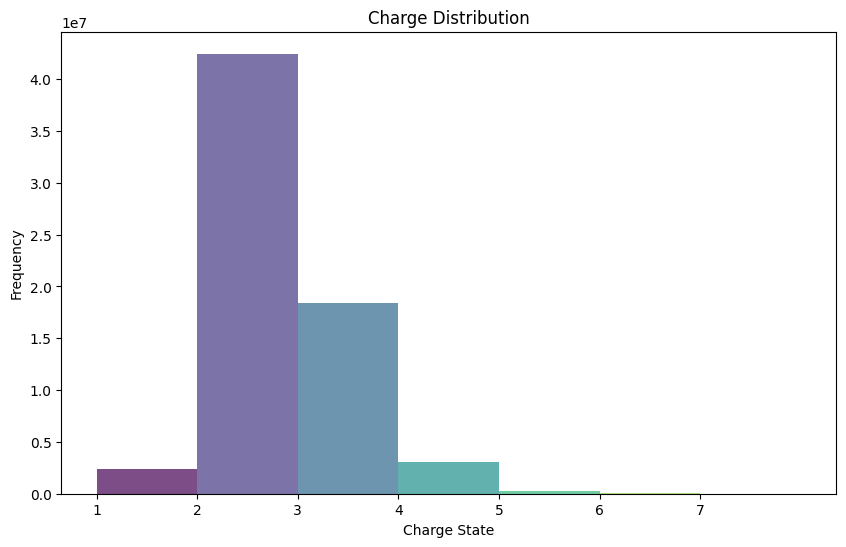

In [44]:
# Number of unique charge states
unique_charges = unprocessed_df['precursor_charge'].nunique()

# Extracting colors from the 'viridis' colormap
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1, unique_charges)]

# Plotting the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(unprocessed_df['precursor_charge'], bins=range(1, max(unprocessed_df['precursor_charge']) + 2), color='grey', alpha=0.7, label='Charge Distribution')

for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

plt.xlabel('Charge State')
plt.ylabel('Frequency')
plt.title('Charge Distribution')
plt.xticks(range(1, max(unprocessed_df['precursor_charge']) + 1))
plt.show()

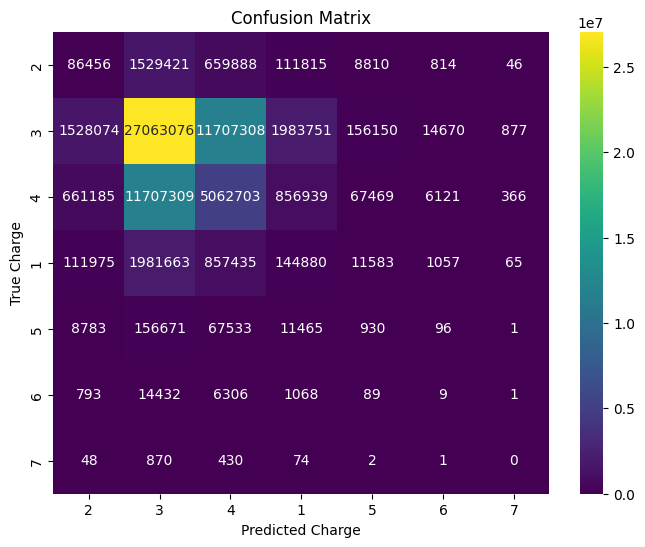

In [50]:
# Generate confusion matrix for biased random predictor
conf_matrix = confusion_matrix(unprocessed_df['precursor_charge'], unprocessed_df['biased_random_prediction'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=charges, yticklabels=charges)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Charge')
plt.ylabel('True Charge')
plt.show()

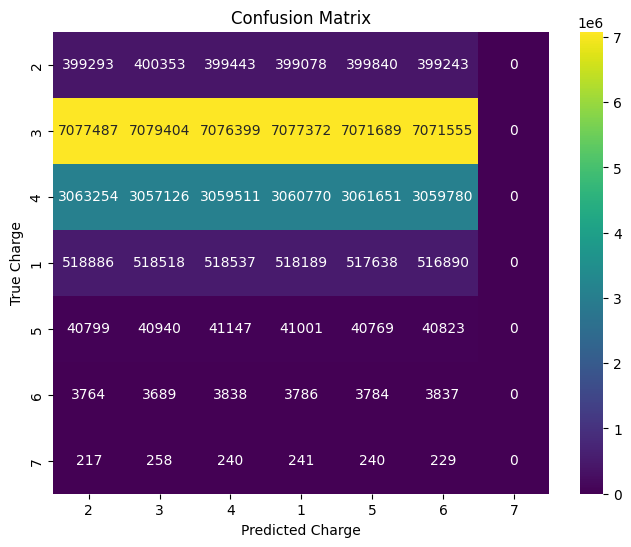

In [51]:
# Generate confusion matrix for random predictor
conf_matrix = confusion_matrix(unprocessed_df['precursor_charge'], unprocessed_df['random_prediction'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=charges, yticklabels=charges)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Charge')
plt.ylabel('True Charge')
plt.show()